In [1]:
import pandas as pd
df = pd.read_csv('data/insurance_data.csv', index_col=0)

In [2]:
df.head()

,PatientID,age,gender,bmi,bloodpressure,diabetic,children,smoker,region,claim
index,,,,,,,,,,
0,1,39.0,male,23.2,91,Yes,0,No,southeast,1121.87
1,2,24.0,male,30.1,87,No,0,No,southeast,1131.51
2,3,NaN,male,33.3,82,Yes,0,No,southeast,1135.94
3,4,NaN,male,33.7,80,No,0,No,northwest,1136.40
4,5,NaN,male,34.1,100,No,0,No,northwest,1137.01


In [3]:
df.rename(columns={'bmi': 'imc'}, inplace=True)

In [4]:
df.columns

Index(['PatientID', 'age', 'gender', 'imc', 'bloodpressure', 'diabetic',
       'children', 'smoker', 'region', 'claim'],
      dtype='object')

In [5]:
len(df)

1340

In [6]:
df.isnull().sum()

PatientID        0
age              5
gender           0
imc              0
bloodpressure    0
diabetic         0
children         0
smoker           0
region           3
claim            0
dtype: int64

## Quantidade insignificante de NAN values então irei removélos do dataset.

In [7]:
df = df.dropna()

In [8]:
df_numerico = df.iloc[:, 1:]

In [9]:
df_numerico.describe()

,age,imc,bloodpressure,children,claim
count,1332.000000,1332.000000,1332.000000,1332.000000,1332.000000
mean,38.086336,30.658333,94.189189,1.099850,13325.246426
std,11.112804,6.118967,11.445173,1.205958,12109.620712
min,18.000000,16.000000,80.000000,0.000000,1121.870000
25%,29.000000,26.200000,86.000000,0.000000,4760.157500
50%,38.000000,30.350000,92.000000,1.000000,9412.965000
75%,47.000000,34.725000,99.000000,2.000000,16781.327500
max,60.000000,53.100000,140.000000,5.000000,63770.430000


## Não parece ter nenhum dado que chame muita atenção principalmente nas colunas inteiras, vamos calcular o IQR das colunas numéricas para observarmos se realmente os dados estão seguindo uma distribuição normal ou não.

In [10]:
def remover_outliers_iqr(df_numerico):
    """
    Remove outliers de um DataFrame numérico usando o método IQR.

    Para cada coluna numérica, identifica outliers usando o intervalo interquartil (IQR)
    e remove as linhas que contêm outliers em qualquer coluna.

    Args:
        df_numerico: DataFrame pandas contendo apenas colunas numéricas.

    Returns:
        DataFrame pandas com os outliers removidos.
    """
    df_sem_outliers = df_numerico.copy() 

    for column in df_sem_outliers.columns:
        if pd.api.types.is_numeric_dtype(df_sem_outliers[column]): # Para pegar apenas as colunas númericas e ignorar boolean
            Q1 = df_sem_outliers[column].quantile(0.25)
            Q3 = df_sem_outliers[column].quantile(0.75)
            IQR = Q3 - Q1

            limite_inferior = Q1 - 1.5 * IQR
            limite_superior = Q3 + 1.5 * IQR

            outliers = df_sem_outliers[(df_sem_outliers[column] < limite_inferior) | (df_sem_outliers[column] > limite_superior)]

            if not outliers.empty:
                print(f"Outliers removidos da coluna '{column}':")
                print(outliers[column])
                print(f"Quantidade de outliers removidos: {len(outliers)}")

                # Remove as linhas que contêm outliers da coluna atual
                df_sem_outliers = df_sem_outliers.drop(outliers.index)
                df_sem_outliers = df_sem_outliers.reset_index(drop=True)

                print("-" * 50)
            else:
                print(f"Não foram encontrados outliers significativos na coluna '{column}'.")
                print("-" * 50)
    return df_sem_outliers

df_sem_outliers = remover_outliers_iqr(df_numerico)

Não foram encontrados outliers significativos na coluna 'age'.
--------------------------------------------------
Outliers removidos da coluna 'imc':
index
9       53.1
141     50.4
675     48.1
696     47.7
802     49.1
1299    52.6
1306    47.6
Name: imc, dtype: float64
Quantidade de outliers removidos: 7
--------------------------------------------------
Outliers removidos da coluna 'bloodpressure':
1134    128
1137    135
1139    128
1140    126
1141    126
       ... 
1310    133
1317    120
1318    127
1319    125
1321    120
Name: bloodpressure, Length: 62, dtype: int64
Quantidade de outliers removidos: 62
--------------------------------------------------
Não foram encontrados outliers significativos na coluna 'children'.
--------------------------------------------------
Outliers removidos da coluna 'claim':
1148    28868.66
1149    28923.14
1150    28950.47
1151    29186.48
1152    29330.98
          ...   
1258    48970.25
1259    55135.40
1260    60021.40
1261    62592.87
1

## A intuição inicial estava errada e existem uma grande quantidade de outliers, principalmente na coluna de claim, coluna essa que será o nosso rótulo

## Vamos utilizar a coluna de Claim como nosso target para o classificador, assim vamos fazer uma análise da distriuição desses dados.

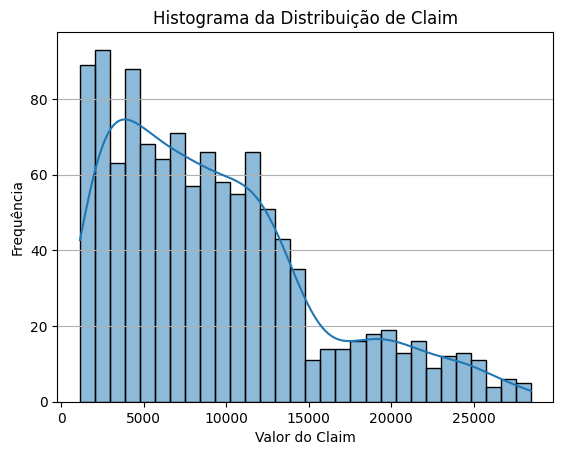

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(data=df_sem_outliers['claim'], kde=True, bins=30)
plt.title('Histograma da Distribuição de Claim')
plt.xlabel('Valor do Claim')
plt.ylabel('Frequência')
plt.grid(axis='y')
plt.show()

In [12]:
from sklearn.cluster import KMeans
def create_cluster_bins(df, column, num_clusters):
    kmeans = KMeans(n_clusters=num_clusters, random_state=0, n_init=10)
    df['cluster'] = kmeans.fit_predict(df[[column]])
    centroids = sorted(kmeans.cluster_centers_.flatten())
    min_val = df[column].min()
    max_val = df[column].max()
    epsilon = (max_val - min_val) * 0.0001 # Para evitar que o maior valor não esteja no grupo
    bins = [min_val] + centroids + [max_val + epsilon]

    labels = []
    for i in range(len(bins) - 1):
        labels.append(f'[{bins[i]:.2f} to {bins[i+1]:.2f})')

    if len(labels) != len(bins) - 1:
        labels = [f'[{bins[i]:.2f} to {bins[i+1]:.2f})' for i in range(len(bins) - 1)]

    df['binned_claim'] = pd.cut(df[column], bins=bins, labels=labels, include_lowest=True, right=False)
    return df

df_binned = create_cluster_bins(df_sem_outliers, 'claim', 4)

c:\Users\Tales\Python\cienciaDados\unidade3\.venv\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Tales\Python\cienciaDados\unidade3\.venv\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "C:\Users\Tales\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "C:\Users\Tales\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 971, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\Tales\AppData\Local\Programs\Python\Python310\lib\subprocess.py"

C:\Users\Tales\AppData\Local\Temp\ipykernel_15484\40147910.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Cluster')


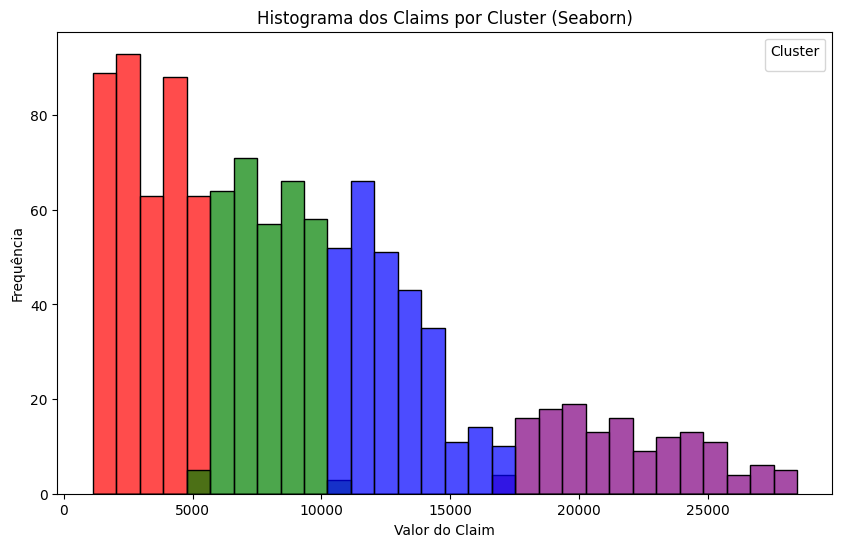

In [13]:
cores = {
    0: 'blue',
    1: 'green',
    2: 'red',
    3: 'purple',
    4: 'orange',
    5: 'brown',
    6: 'pink',
    7: 'gray',
    8: 'cyan',
    9: 'lime'
}

plt.figure(figsize=(10, 6))
sns.histplot(data=df_binned, x='claim', hue='cluster', palette=cores, bins=30, kde=False, alpha=0.7, legend=True)
plt.xlabel("Valor do Claim")
plt.ylabel("Frequência")
plt.title("Histograma dos Claims por Cluster (Seaborn)")
plt.legend(title='Cluster')
plt.show()

In [14]:
df_binned['binned_claim'].value_counts()

binned_claim
[3276.72 to 7897.55)      353
[7897.55 to 12774.96)     321
[1121.87 to 3276.72)      205
[12774.96 to 21736.46)    203
[21736.46 to 28479.47)     66
Name: count, dtype: int64

In [15]:
df_binned.head()

,age,gender,imc,bloodpressure,diabetic,children,smoker,region,claim,cluster,binned_claim
0,39.0,male,23.2,91,Yes,0,No,southeast,1121.87,2,[1121.87 to 3276.72)
1,24.0,male,30.1,87,No,0,No,southeast,1131.51,2,[1121.87 to 3276.72)
2,19.0,male,41.1,100,No,0,No,northwest,1146.80,2,[1121.87 to 3276.72)
3,20.0,male,43.0,86,No,0,No,northwest,1149.40,2,[1121.87 to 3276.72)
4,36.0,male,19.8,88,Yes,0,No,northwest,1241.57,2,[1121.87 to 3276.72)


## Vamos lidar agora com a region e gender, as únicas colunas textuais e categoricas, nesse caso não podemos simplesmente transformar em boolean ou categorica numérica, já que não existe ordem entre essas classes. Por isso vamos utilizar o One hot encoder transformando cada possível categoria em uma coluna binária.

In [16]:
df_encoded = pd.get_dummies(df_binned, columns=['region'])
df_encoded = pd.get_dummies(df_encoded, columns=['gender'])

In [17]:
df_encoded.head()

,age,imc,bloodpressure,diabetic,children,smoker,claim,cluster,binned_claim,region_northeast,region_northwest,region_southeast,region_southwest,gender_female,gender_male
0,39.0,23.2,91,Yes,0,No,1121.87,2,[1121.87 to 3276.72),False,False,True,False,False,True
1,24.0,30.1,87,No,0,No,1131.51,2,[1121.87 to 3276.72),False,False,True,False,False,True
2,19.0,41.1,100,No,0,No,1146.80,2,[1121.87 to 3276.72),False,True,False,False,False,True
3,20.0,43.0,86,No,0,No,1149.40,2,[1121.87 to 3276.72),False,True,False,False,False,True
4,36.0,19.8,88,Yes,0,No,1241.57,2,[1121.87 to 3276.72),False,True,False,False,False,True


## As colunas diabetic e smoker parecem booleanas mas não são, vamos modificar isso

In [18]:
mapping = {'Yes': True, 'No': False}

df_encoded['diabetic'] = df_encoded['diabetic'].map(mapping)
df_encoded['smoker'] = df_encoded['smoker'].map(mapping)

In [19]:
df_encoded.head()

,age,imc,bloodpressure,diabetic,children,smoker,claim,cluster,binned_claim,region_northeast,region_northwest,region_southeast,region_southwest,gender_female,gender_male
0,39.0,23.2,91,True,0,False,1121.87,2,[1121.87 to 3276.72),False,False,True,False,False,True
1,24.0,30.1,87,False,0,False,1131.51,2,[1121.87 to 3276.72),False,False,True,False,False,True
2,19.0,41.1,100,False,0,False,1146.80,2,[1121.87 to 3276.72),False,True,False,False,False,True
3,20.0,43.0,86,False,0,False,1149.40,2,[1121.87 to 3276.72),False,True,False,False,False,True
4,36.0,19.8,88,True,0,False,1241.57,2,[1121.87 to 3276.72),False,True,False,False,False,True


## Vamos extrair o nosso dataframe com o pré processamento

In [20]:
df_encoded.to_csv('artefatos/insurance_data_preprocessado.csv', index=False)